In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
import time
import sys, os

In [2]:
def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2)
    elif t=='each':
        x=x.dropna().values
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2)
    else:
        return  np.percentile(np.sort(x),val)

In [3]:
def each_percentile(x,val):
    return (x<val).sum()/len(x)

In [4]:
# RSI, %time above RSI
def RSI(series, period=14):
 #print(len(series))
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / pd.stats.moments.ewma(d, com=period-1, adjust=False)
 rs = pd.Series.ewm(u, com=period-1).mean()/pd.Series.ewm(d, com=period-1).mean()
 rsi = 100 - 100 / (1 + rs)
 return rsi
 return np.round(rsi.values[-1],2),get_percentile(rsi)#np.round(100*np.sum(np.where(rsi>rsi.values[-1],1,0))/len(rsi),2)

In [5]:
# Consecutive increases, hist percentile, hist change mean 4 week, slope of 4 week macd
def macd_calcs(x):
    macd=x.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-x.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
    signal=macd.ewm(span=9,min_periods=0,adjust=True,ignore_na=True).mean()
    macd_hist=macd-signal
    return macd_hist
    return consecutive_increases(macd_hist), get_percentile(macd_hist),(macd_hist/macd_hist.shift(1)-1).rolling(4).mean().values[-1:][0],np.polyfit(x=[1,2,3,4],y=macd.values[-4:],deg=1,full=False)[0]

In [6]:
w=pd.read_csv('spy.csv')

In [7]:
w=w.astype({'Date': 'datetime64'})

In [8]:
#temp_res=
w['rsi']=RSI(w.adj_close)

In [9]:
w.set_index('Date', inplace=True)

In [10]:
262.18/259.98

1.0084621893991845

In [11]:
w.tail(10)

,open,high,low,close,adj_close,highest_high,lowest_low,k,k_change,ret,ret_p,rsi
Date,,,,,,,,,,,,
2020-08-11,336.85,337.5400,332.0100,332.80,332.80,337.54,312.000,0.931062,-0.063204,0.008302,0.619630,64.320947
2020-08-12,335.44,338.2800,332.8377,337.44,337.44,338.28,312.000,0.924677,-0.065613,0.016049,0.775062,69.114591
2020-08-13,336.61,338.2514,335.8300,336.83,336.83,338.28,319.090,0.902295,-0.089605,0.007478,0.599771,67.824456
2020-08-14,336.41,337.4200,335.6200,336.84,336.84,338.28,319.090,0.939146,0.008683,0.006785,0.581058,67.835056
2020-08-17,337.94,338.3400,336.8517,337.91,337.91,338.34,319.246,0.942294,0.019051,0.006973,0.587932,69.011435
2020-08-18,338.34,339.1000,336.6100,338.64,338.64,339.10,319.246,0.959757,0.063684,0.017548,0.803132,69.822347
2020-08-19,339.05,339.6100,336.6200,337.23,337.23,339.61,319.246,0.945813,0.007099,-0.000622,0.407103,66.217979
2020-08-20,335.36,338.8000,335.2200,338.28,338.28,339.61,319.246,0.931549,-0.011403,0.004305,0.522437,67.560923
2020-08-21,337.92,339.7200,337.5500,339.48,339.48,339.72,319.246,0.935365,-0.025415,0.007838,0.609509,69.074039


In [12]:
w['ret']=w.adj_close/w.adj_close.shift(5)-1
w['ret_day']=w.adj_close/w.adj_close.shift(1)-1
w['ret_month']=w.adj_close/w.adj_close.shift(22)-1

In [13]:
inverse=w.sort_values(by='Date', ascending=False).adj_close

In [14]:
w['post_ret']=(inverse.shift(5)/inverse-1).sort_values()
w['post_ret_day']=(inverse.shift(1)/inverse-1).sort_values()
w['post_ret_month']=(inverse.shift(22)/inverse-1).sort_values()

In [15]:
#w['post_ret']=w.adj_close.shift(5)/w.adj_close-1
#w['post_ret_day']=w.adj_close.shift(1)/w.adj_close-1
#w['post_ret_month']=w.adj_close.shift(22)/w.adj_close-1

In [16]:
np.nanpercentile(w.k_change,q=10),np.nanpercentile(w.ret,q=10)

(-0.4513547165648985, -0.02648284785577889)

In [17]:
w['ret_p']=w.ret.apply(lambda x: each_percentile(w.ret,x))
w['rsi_p']=w.rsi.apply(lambda x: each_percentile(w.rsi,x))

In [18]:
w['has_hit_ten']=w.ret_p.apply(lambda x: 1 if x<=0.1 else 0)


In [19]:
w['macd_hist']=macd_calcs(w.adj_close)
w['macd_p']=w.macd_hist.apply(lambda x: each_percentile(w.macd_hist,x))

In [21]:
w[w.has_hit_ten==1].tail(30)

,open,high,low,close,adj_close,highest_high,lowest_low,k,k_change,ret,...,rsi,ret_day,ret_month,post_ret,post_ret_day,post_ret_month,rsi_p,has_hit_ten,macd_hist,macd_p
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-06,285.91,288.0400,284.2800,287.80,282.0865,302.2300,281.7200,0.183546,-0.592440,-0.042964,...,37.171640,0.014023,-0.035716,0.016505,0.000591,0.035615,0.080771,1,-1.925893,0.006683
2019-08-07,284.40,288.8200,282.0400,287.97,282.2531,302.2300,281.7200,0.234520,0.081362,-0.031806,...,37.539116,0.000591,-0.029816,-0.014133,0.019620,0.035524,0.085736,1,-1.898298,0.007256
2019-08-15,284.88,285.6400,282.3900,284.65,278.9990,302.2300,281.7200,0.259061,-0.433748,-0.030550,...,39.253307,0.002642,-0.050249,0.027086,0.014755,0.057158,0.107122,1,-1.202924,0.015467
2019-10-02,291.50,291.5100,286.6400,288.06,283.6510,302.6300,286.6400,0.315779,-0.519558,-0.032121,...,35.872618,-0.017665,-0.010451,0.011143,0.008193,0.062764,0.063204,1,-1.106594,0.019668
2020-02-24,323.14,333.5623,321.2400,322.42,319.0392,339.0800,320.7300,0.556948,-0.413706,-0.044964,...,37.249690,-0.033165,-0.026921,-0.041344,-0.030302,-0.229868,0.081535,1,-1.003047,0.023678
2020-02-25,323.94,324.6100,311.6900,312.65,309.3716,339.0800,311.6900,0.273990,-0.702580,-0.071511,...,28.672248,-0.030302,-0.057488,-0.039693,-0.003678,-0.159429,0.011648,1,-2.189476,0.004965
2020-02-26,314.18,318.1100,310.7000,311.50,308.2337,339.0800,310.7000,0.051779,-0.938806,-0.079328,...,27.859095,-0.003678,-0.052529,0.004366,-0.044912,-0.181455,0.009929,1,-2.912350,0.003055
2020-02-27,305.46,311.5637,297.5100,297.51,294.3904,339.0800,297.5100,0.021079,-0.962152,-0.117050,...,20.311955,-0.044912,-0.080340,0.016638,-0.004202,-0.115131,0.001719,1,-4.110973,0.001719
2020-02-28,288.70,297.8920,285.5400,296.26,293.1535,339.0800,285.5400,0.076138,-0.722115,-0.111611,...,19.795930,-0.004202,-0.093701,0.004050,0.043307,-0.124643,0.001528,1,-4.731071,0.001528


In [88]:
cols=['adj_close','k','k_change','ret_day','ret','ret_month','ret_p','k_change','macd_p','has_hit_ten']

In [106]:
w['2020-06-1':'2020-07-18'][cols]

,adj_close,k,k_change,ret_day,ret,ret_month,ret_p,k_change,macd_p,has_hit_ten
Date,,,,,,,,,,
2020-06-01,304.2034,0.924372,-0.007658,0.004042,0.034220,0.042086,0.941649,-0.007658,0.979721,0
2020-06-02,306.7223,0.962007,0.038938,0.008280,0.030092,0.060589,0.922135,0.038938,0.983547,0
2020-06-03,310.8042,0.978205,0.044378,0.013308,0.028498,0.103929,0.912187,0.044378,0.990243,0
2020-06-04,309.9878,0.975497,0.055308,-0.002627,0.027692,0.098000,0.907786,0.055308,0.989669,0
2020-06-05,317.9327,0.962613,0.000630,0.025630,0.049356,0.115832,0.975703,0.000630,0.992730,0
2020-06-08,321.7757,0.969842,-0.008550,0.012087,0.057765,0.137027,0.985269,-0.008550,0.994069,0
2020-06-09,319.3763,0.967932,-0.007755,-0.007457,0.041256,0.115093,0.964607,-0.007755,0.993687,0
2020-06-10,317.5942,0.952135,-0.010885,-0.005580,0.021847,0.090822,0.857662,-0.010885,0.992156,0
2020-06-11,299.2852,0.802790,-0.172247,-0.057649,-0.034526,0.027727,0.064664,-0.172247,0.403482,1


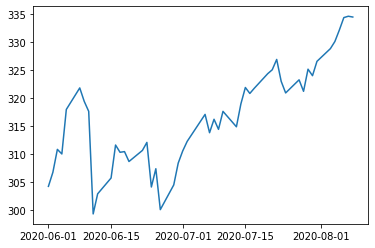

In [77]:
plt.plot(w['2020-06-1':'2020-08-18'].adj_close)

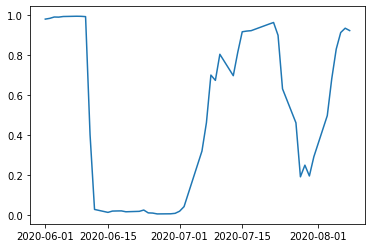

In [85]:
plt.plot(w['2020-06-1':'2020-08-18'].macd_p)

In [23]:
w.reset_index().dtypes

Date              datetime64[ns]
Unnamed: 0                 int64
open                     float64
high                     float64
low                      float64
close                    float64
adj_close                float64
highest_high             float64
lowest_low               float64
k                        float64
k_change                 float64
rsi                      float64
ret                      float64
ret_day                  float64
ret_month                float64
post_ret                 float64
post_ret_day             float64
post_ret_month           float64
ret_p                    float64
rsi_p                    float64
has_hit_ten                int64
dtype: object

In [24]:
#w.dropna(inplace=True)

In [87]:
x=80
diff=5
w[(w.macd_p>=(x-diff)) & (w.macd_p<=(x+diff))].tail(15)#.ret_month.describe()


,Unnamed: 0,open,high,low,close,adj_close,highest_high,lowest_low,k,k_change,...,ret_day,ret_month,post_ret,post_ret_day,post_ret_month,ret_p,rsi_p,has_hit_ten,macd_hist,macd_p
Date,,,,,,,,,,,,,,,,,,,,,


In [26]:
len(w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))])/len(w),np.sum(w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))].has_hit_ten)/len(w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))])

(0.11119812059514488, 0.0)

In [27]:
w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))].post_ret_month.mean(),w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))].post_ret.mean(),w[(w.rsi>=(x-diff)) & (w.rsi<=(x+diff))].post_ret_day.mean()

(0.04557435483814253, 0.011452142902299154, 0.0035014622911441634)

In [28]:
w[w.post_ret_day>0].ret.describe()

count    684.000000
mean       0.008026
std        0.057674
min       -0.305432
25%       -0.023364
50%        0.009067
75%        0.039582
max        0.216642
Name: ret, dtype: float64

In [29]:
w[w.post_ret_day<0].ret.describe()

count    573.000000
mean       0.008087
std        0.057997
min       -0.305055
25%       -0.026201
50%        0.007830
75%        0.037534
max        0.216304
Name: ret, dtype: float64

In [56]:
w[w.has_hit_ten==1].post_ret_day.describe()

count    528.000000
mean       0.002596
std        0.032334
min       -0.119788
25%       -0.015236
50%        0.002980
75%        0.018202
max        0.168413
Name: post_ret_day, dtype: float64

In [95]:
w[(w.macd_p<0.9) & (w.macd_p>0.8)].post_ret.describe()

count    522.000000
mean       0.001858
std        0.021154
min       -0.117050
25%       -0.006383
50%        0.004028
75%        0.013097
max        0.108270
Name: post_ret, dtype: float64

In [92]:
len(w[w.macd_p<0.1])/len(w)

0.10005739429883298

In [102]:
cons=[]
cons_list=[]
last=-999
c=0
for idx,val in enumerate(w.macd_hist):
 
    if val>last:
        c+=1
        cons.append(1)
    else:
        cons.append(0)
    if val<=last and c>0:
        print(c)
        c=0
    
    last=val
    

1
4
7
3
2
3
6
3
4
7
1
1
6
2
8
1
9
2
5
1
7
1
1
2
8
1
7
3
1
1
1
2
1
1
2
4
2
2
4
5
1
2
2
1
4
2
4
2
10
1
1
1
2
6
1
6
11
1
1
5
4
11
6
6
1
1
1
4
1
1
10
2
1
1
7
2
1
3
9
3
1
4
3
5
1
10
2
1
1
1
4
4
2
5
1
1
1
1
3
2
2
1
1
7
5
4
1
4
1
2
2
1
8
3
2
4
2
2
2
4
6
2
1
5
2
6
1
2
1
7
3
2
4
1
1
1
2
10
2
2
1
6
3
2
3
1
11
5
1
4
1
10
8
2
7
1
2
6
2
4
1
1
1
5
1
8
3
10
4
3
4
11
2
1
1
3
1
1
5
2
11
1
1
7
1
1
10
1
3
6
3
2
1
1
3
11
3
2
5
10
1
1
5
5
1
6
6
2
2
7
1
1
1
2
1
1
3
1
10
1
6
4
4
6
2
5
3
2
7
3
1
8
1
1
1
6
3
5
2
1
4
1
3
3
8
4
2
6
2
4
1
2
5
1
4
3
3
4
3
6
2
3
1
2
1
2
5
1
7
5
5
9
4
4
1
1
2
1
2
5
1
5
8
4
2
3
1
8
1
2
4
2
1
1
1
7
1
4
1
1
5
4
4
4
9
7
4
3
5
3
4
2
2
1
6
3
1
3
1
1
2
1
3
6
2
2
2
1
2
1
2
3
3
2
2
4
1
6
1
1
5
2
4
1
5
7
5
3
1
10
1
1
2
2
2
1
6
1
2
1
4
1
1
6
11
1
6
9
1
9
1
1
7
3
2
5
5
6
1
1
1
3
9
3
2
1
3
2
2
1
2
1
1
4
1
7
9
8
4
1
1
2
1
13
1
1
2
1
2
1
1
5
3
1
1
9
2
3
4
4
6
2
3
2
2
2
13
7
1
2
4
1
2
6
8
4
1
5
7
1
3
2
1
9
1
2
2
1
1
1
1
8
1
5
1
3
1
3
1
6
3
3
1
8
1
1
1
5
7
7
6
5
1
4
5
4
4
1
8
5
4
6
10
2
2
1
5
1
4
1


In [105]:
w['macd_cons']=pd.Series(cons)

In [108]:
len(cons)

5227

In [110]:
len(w)

5227

In [127]:
cycle_date=pd.to_datetime('2020-03-01')

In [223]:
w=pd.read_csv('cwh.csv')
w=w.astype({'Date': 'datetime64'})
w.set_index('Date',inplace=True)

spy=pd.read_csv('spy.csv')
spy=spy.astype({'Date': 'datetime64'})
spy.set_index('Date',inplace=True)

qqq=pd.read_csv('tsla.csv')
qqq=qqq.astype({'Date': 'datetime64'})
qqq.set_index('Date',inplace=True)

In [224]:
w['ret']=w.adj_close/w.adj_close.shift(5)-1
w['ret_day']=w.adj_close/w.adj_close.shift(1)-1
w['ret_month']=w.adj_close/w.adj_close.shift(22)-1
w['ret5day_mean']=w.ret.rolling(4).mean()

spy['ret']=spy.adj_close/spy.adj_close.shift(5)-1
spy['ret_day']=spy.adj_close/spy.adj_close.shift(1)-1
spy['ret_month']=spy.adj_close/spy.adj_close.shift(22)-1
spy['ret5day_mean']=spy.ret.rolling(4).mean()

qqq['ret']=qqq.adj_close/qqq.adj_close.shift(5)-1
qqq['ret_day']=qqq.adj_close/qqq.adj_close.shift(1)-1
qqq['ret_month']=qqq.adj_close/qqq.adj_close.shift(22)-1
qqq['ret5day_mean']=qqq.ret.rolling(4).mean()

In [225]:
np.nanpercentile(w.ret_day,90),np.nanpercentile(qqq.ret_day,90),np.nanpercentile(spy.ret_day,90)

(0.04432796834590063, 0.03689534620270374, 0.012358906100470413)

In [226]:
sum(w[cycle_date:].ret_day>0),sum(qqq[cycle_date:].ret_day>0),sum(spy[cycle_date:].ret_day>0)

(60, 62, 68)

In [227]:
w['score']=(w['ret']-spy['ret'])+(w['ret_month']-spy['ret_month'])+(w['ret5day_mean']-spy['ret5day_mean'])
qqq['score']=(qqq['ret']-spy['ret'])+(qqq['ret_month']-spy['ret_month'])+(qqq['ret5day_mean']-spy['ret5day_mean'])

In [228]:
w.tail(10)

,Unnamed: 0,open,high,low,close,adj_close,highest_high,lowest_low,k,k_change,ret,ret_day,ret_month,ret5day_mean,score
Date,,,,,,,,,,,,,,,
2020-07-28,9,37.740,38.920,36.3100,36.450,36.450,39.240,25.12,0.811514,-0.093496,-0.007893,-0.045062,0.409513,0.026972,0.398205
2020-07-29,8,36.900,37.000,34.3875,34.820,34.820,39.240,25.12,0.804657,-0.014270,-0.090624,-0.044719,0.373570,0.001983,0.212485
2020-07-30,7,34.440,37.500,34.2500,36.520,36.520,39.240,25.12,0.765581,-0.035776,0.023256,0.048823,0.359137,0.007939,0.327546
2020-07-31,6,36.830,37.250,35.1099,36.620,36.620,39.240,25.12,0.769594,-0.051657,0.043602,0.002738,0.348306,-0.007915,0.306641
2020-08-03,5,38.000,40.665,37.6200,40.050,40.050,40.665,25.12,0.860750,0.069710,0.049253,0.093665,0.433942,0.006372,0.405352
2020-08-04,4,39.980,41.280,38.2000,39.060,39.060,41.280,25.12,0.879170,0.148370,0.071605,-0.024719,0.408075,0.046929,0.425427
2020-08-05,3,40.340,42.490,40.0100,42.290,42.290,42.490,25.12,0.937182,0.217762,0.214532,0.082693,0.598866,0.094748,0.818148
2020-08-06,2,40.900,41.580,32.8000,33.000,33.000,42.490,25.12,0.768255,-0.107459,-0.096386,-0.219674,0.296151,0.059751,0.137409
2020-08-07,1,34.150,34.300,30.5200,32.370,32.370,42.490,25.54,0.615030,-0.300442,-0.116057,-0.019091,0.198445,0.018424,-0.008466


In [229]:
qqq.tail(10)

,Unnamed: 0,open,high,low,close,adj_close,highest_high,lowest_low,k,k_change,ret,ret_day,ret_month,ret5day_mean,score
Date,,,,,,,,,,,,,,,
2020-07-28,9,1504.0000,1564.7000,1474.4200,1476.490,1476.490,1794.99,948.5201,0.628463,-0.131529,-0.058577,-0.040991,0.497485,-0.042272,0.366248
2020-07-29,8,1501.0000,1534.8100,1487.0000,1499.110,1499.110,1794.99,948.5201,0.658824,-0.009032,-0.058543,0.015320,0.561996,-0.058979,0.372030
2020-07-30,7,1488.0000,1513.2400,1471.0000,1487.490,1487.490,1794.99,1003.7300,0.628522,-0.024549,-0.016906,-0.007751,0.473711,-0.049240,0.344779
2020-07-31,6,1515.0000,1517.0500,1420.9800,1430.760,1430.760,1794.99,1080.5000,0.584019,-0.070718,0.009711,-0.038138,0.325011,-0.031079,0.226290
2020-08-03,5,1449.2000,1509.8101,1444.3844,1485.000,1485.000,1794.99,1185.6000,0.530971,-0.194062,-0.035464,0.037910,0.326331,-0.025301,0.181351
2020-08-04,4,1495.0100,1527.4100,1462.0000,1487.000,1487.000,1794.99,1266.0400,0.466423,-0.257905,0.007118,0.001347,0.230288,-0.008885,0.127339
2020-08-05,3,1492.9900,1499.8384,1468.3100,1485.020,1485.020,1794.99,1311.3400,0.422716,-0.276196,-0.009399,-0.001332,0.082708,-0.007008,-0.023697
2020-08-06,2,1490.8300,1517.3100,1477.2600,1489.580,1489.580,1794.99,1311.3400,0.381789,-0.280961,0.001405,0.003071,0.071748,-0.009085,-0.058039
2020-08-07,1,1499.5365,1499.7500,1415.0100,1452.710,1452.710,1794.99,1351.2800,0.318743,-0.316622,0.015341,-0.024752,0.063571,0.003616,-0.026749


In [210]:
spy.iloc[-1]

Unnamed: 0        0.000000
open            334.650000
high            334.680000
low             334.350000
close           334.430000
adj_close       334.430000
highest_high    334.880000
lowest_low      312.000000
k                 0.987352
k_change          0.006379
ret               0.017154
ret_day          -0.000418
ret_month         0.063776
ret5day_mean      0.023829
Name: 2020-08-08 00:00:00, dtype: float64

In [214]:
columns=['ret','ret_month','ret5day_mean']

In [215]:
score=0
for c in columns:
    score+=w.iloc[-1][c]-spy.iloc[-1][c]
    #score+=w.iloc[-1][c]-qqq.iloc[-1][c]

In [216]:
score

0.034642089832147616

Big drops could be on earnings so need earnings date for analysis
Consistency is more important for options than stocks
1). Little power in k/rsi/ etc. relentlessly buy on dips then 
but how to know when to sell

It is quite likely it heals itself in most cases Brexit, 2020-06-11 (it took 1 month)
so index OTM should be quite safe and if not safer index bets on 
drop days 

so just have momentum score with watch on earnings?

10 day mean
5day> spy&qqq 
22day> spy&qqq 
5day mean > spy&qqq 
cycle >= 2x spy&qqq

sector/peers

1 point score 
cons weeks 
5day> spy&qqq 
22day> spy&qqq 
5day mean > spy&qqq 
cycle >= 2x spy&qqq

score for earnings 